In [225]:
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [226]:
#Função Sphere
def sphere(vetor, limite_inferior=-100, limite_superior=100):
  resultado = 0
  
  for i in vetor:
    resultado += i**2
  
  return resultado

#Função rastrigin
def rastrigin(vetor, limite_inferior=-30, limite_superior=30):
  resultado = 0
  
  for i in vetor:
    x = 2*math.pi*i
    resultado += 10 + ((i**2) - 10 * math.cos(x))
    

  return resultado 

#Função rosenbrock
def rosenbrock(vetor, limite_inferior=-5.12, limite_superior=5.12):
  resultado = 0
  
  for i in range(0,(len(vetor)-1)):
    resultado += 100*(vetor[i+1] - vetor[i]**2)**2 + (vetor[i] - 1)**2
    
  return resultado

In [227]:
class Inercia(Enum):
    CONSTANTE = 0
    DECAIMENTO_LINEAR = 1

In [228]:
class Cooperacao(Enum):
    GLOBAL = 0
    LOCAL_GEOGRAFICA = 1
    LOCAL_SOCIAL = 2

In [229]:
# FALTA

class AlgoritmoEnxameParticulas:
    def __init__(self, funcao, limite_funcao, limite_velocidade, limite_posicao, w_tipo, tipo_cooperacao, qtd_conexoes=0, dimensao=3, qtd_particulas=30, qtd_iteracoes=100, w_valor=1, w_max=1, w_min=0.8, c1=2.05, c2=2.05, tipo_problema=float):
        self.funcao = funcao
        self.limite_funcao = limite_funcao
        self.limite_velocidade = limite_velocidade
        self.limite_posicao = limite_posicao
        self.dimensao = dimensao
        self.qtd_particulas = qtd_particulas
        self.qtd_iteracoes = qtd_iteracoes 
        self.w_tipo = w_tipo
        self.w_valor = w_valor 
        self.w_max = w_max
        self.w_min = w_min
        self.c1 = c1
        self.c2 = c2
        self.tipo_cooperacao = tipo_cooperacao
        self.qtd_conexoes = qtd_conexoes
        self.tipo_problema = tipo_problema
        self.velocidade_particulas = self.gerar_parametros_iniciais(tipo_problema, limite_velocidade[0], limite_velocidade[1]) 
        self.posicao_particulas = self.gerar_parametros_iniciais(tipo_problema, limite_posicao[0], limite_posicao[1])
        self.melhores_cooperacao = []
        self.melhores_pessoais = []
        self.melhores_fitness = [] ## Esse é o histórico de fitness
        self.fitness_iteracao_anterior = [] 
        self.melhor_global = float('inf')
        self.melhor_posicao_global = None

    def otimizar(self):
       for i in range(self.qtd_iteracoes):
            fitness_atual = self.calcular_fitness(self.posicao_particulas)  
            melhor_fitness_iteracao = np.min(fitness_atual)
            indice_melhor_particula = np.argmin(fitness_atual)
            if melhor_fitness_iteracao < self.melhor_global:
                self.melhor_global = melhor_fitness_iteracao
                self.melhor_posicao_global = self.posicao_particulas[indice_melhor_particula].copy()
            self.cooperar(i, self.qtd_conexoes, fitness_atual)
            self.calcular_melhor_pessoal(i, fitness_atual, self.fitness_iteracao_anterior)
            self.atualizar_velocidades(self.velocidade_particulas, self.melhores_pessoais, self.melhores_cooperacao, i)
            self.atualizar_posicoes(self.velocidade_particulas)
            self.puxar_particulas(self.posicao_particulas, self.limite_posicao[0], self.limite_posicao[1])
            self.melhores_fitness.append(self.melhor_global)
            if i == self.qtd_iteracoes - 1:
                print(f"Iteração {i+1} | Melhor solução: {self.melhor_posicao_global} | Fitness: {self.melhor_global} | Histórico Fitness: {self.melhores_fitness}")
    
    def gerar_parametros_iniciais(self, tipo, limite_inferior, limite_superior):
        if (tipo == float):
            return np.random.uniform(low=limite_inferior, high=limite_superior, size=(self.qtd_particulas, self.dimensao))
        elif (tipo == int):
            return np.random.randint(low=limite_inferior, high=limite_superior, size=(self.qtd_particulas, self.dimensao))

    def calcular_fitness(self, particulas):
        return np.array([self.funcao(particula) for particula in particulas])
    
    def cooperar(self, numero_iteracao, qtd_conexoes, fitness_atual): 
        if (numero_iteracao == 0):
            self.melhores_cooperacao = self.posicao_particulas.copy()
        if (self.tipo_cooperacao == Cooperacao.LOCAL_GEOGRAFICA):
            resultado_div_dois = qtd_conexoes // 2
            resto_div_dois = qtd_conexoes - resultado_div_dois
            for i in range(self.qtd_particulas):
                if (i - resultado_div_dois < 0):                    
                    fitness_vizinhos = np.concatenate((fitness_atual[:i], fitness_atual[i:i+(qtd_conexoes-i)+1])) if i > 0 else fitness_atual[i:i+(qtd_conexoes-i)+1]
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)]
                elif (i + resto_div_dois > self.qtd_particulas-1):
                    inicio_final = i-(qtd_conexoes-(self.qtd_particulas-i-1))
                    fitness_vizinhos = np.concatenate((fitness_atual[inicio_final:i], fitness_atual[i:]))
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)+inicio_final]
                else:
                    inicio_meio = i-resultado_div_dois
                    fitness_vizinhos = fitness_atual[inicio_meio:i+resto_div_dois+1] 
                    self.melhores_cooperacao[i] = self.posicao_particulas[np.argmin(fitness_vizinhos)+inicio_meio]
        elif (self.tipo_cooperacao == Cooperacao.LOCAL_SOCIAL):
            for i in range(self.qtd_particulas):
                indices_particulas_sociais = np.random.randint(low=0, high=self.qtd_particulas, size=qtd_conexoes) 
                melhor_fitness = fitness_atual[i]
                for j in indices_particulas_sociais:
                    if (fitness_atual[j] < melhor_fitness):
                        self.melhores_cooperacao[i] = self.posicao_particulas[j]
        elif (self.tipo_cooperacao == Cooperacao.GLOBAL): 
            fitness_cooperacao = self.calcular_fitness(self.melhores_cooperacao)
            indice_melhor_atual = np.argmin(fitness_atual)
            indice_melhor_cooperacao = np.argmin(fitness_cooperacao)
            if (fitness_atual[indice_melhor_atual] < fitness_cooperacao[indice_melhor_cooperacao]):
                for i in range(len(self.melhores_cooperacao)):
                    self.melhores_cooperacao[i] = self.posicao_particulas[indice_melhor_atual]
            else:
                for i in range(len(self.melhores_cooperacao)):
                    self.melhores_cooperacao[i] = self.melhores_cooperacao[indice_melhor_cooperacao]

    def calcular_melhor_pessoal(self, numero_iteracao, fitness_atual, fitness_iteracao_anterior):
        if (numero_iteracao == 0):
            self.melhores_pessoais = self.posicao_particulas.copy()
            self.fitness_iteracao_anterior = self.calcular_fitness(self.posicao_particulas)
        else:
            for i in range(self.qtd_particulas):
                if (fitness_atual[i] < fitness_iteracao_anterior[i]):
                    self.melhores_pessoais[i] = self.posicao_particulas[i]       


    def atualizar_velocidades(self, velocidades, melhores_pessoais, melhores_cooperacao, iteracao_atual):
        if (self.w_tipo == Inercia.DECAIMENTO_LINEAR):
            self.w_valor = (self.w_max - self.w_min) * ((self.qtd_iteracoes - iteracao_atual) / self.qtd_iteracoes) + self.w_min
        r1, r2 = np.random.rand(), np.random.rand()
        valor_local = self.c1 * r1 * (melhores_pessoais - self.posicao_particulas) 
        valor_global = self.c2 * r2 * (melhores_cooperacao - self.posicao_particulas)
        self.velocidade_particulas = self.w_valor * velocidades + valor_local + valor_global

    def atualizar_posicoes(self, velocidades):
        self.posicao_particulas = self.posicao_particulas + velocidades

    def puxar_particulas(self, particulas, limite_inferior, limite_superior):
        for i in range(self.qtd_particulas):
            self.posicao_particulas[i] = [max(min(posicao, limite_superior), limite_inferior) for posicao in particulas[i]]

    def ajustar_velocidades(self, velocidades, limite_inferior, limite_superior):
        for i in range(self.velocidade_particulas):
            self.velocidade_particulas[i] = [max(min(velocidade, limite_superior), limite_inferior) for velocidade in velocidades[i]]

    def plotar_grafico_convergencia(self): 
        valores_x = list(range(self.qtd_iteracoes))
        plt.figure(figsize=(10, 6))
        plt.plot(valores_x, self.melhores_fitness, marker='o', linestyle='-', color='b', label='Fitness')
        plt.xlabel('Iteração')
        plt.ylabel('Melhor Fitness')
        plt.title('Melhor Fitness vs. Iteração')
        plt.grid(True)
        plt.legend()
        plt.show()
    



Iteração 100 | Melhor solução: [ 2.52312744 16.32053811 -3.88352998] | Fitness: 287.8079414263086 | Histórico Fitness: [3640.608924722737, 1608.973032722921, 772.3410657610475, 772.3410657610475, 474.1043620322886, 474.1043620322886, 474.1043620322886, 474.1043620322886, 474.1043620322886, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.8079414263086, 287.80

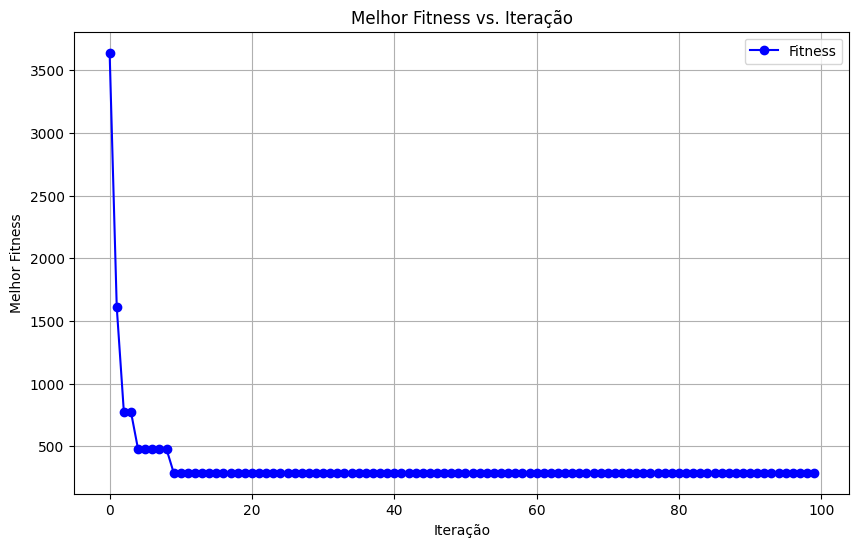

Iteração 100 | Melhor solução: [-0.30717972  3.65889968 -0.29588156] | Fitness: 13.569452166459431 | Histórico Fitness: [280.97048696340175, 111.65037438839472, 75.23732992205314, 75.23732992205314, 75.23732992205314, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13.569452166459431, 13

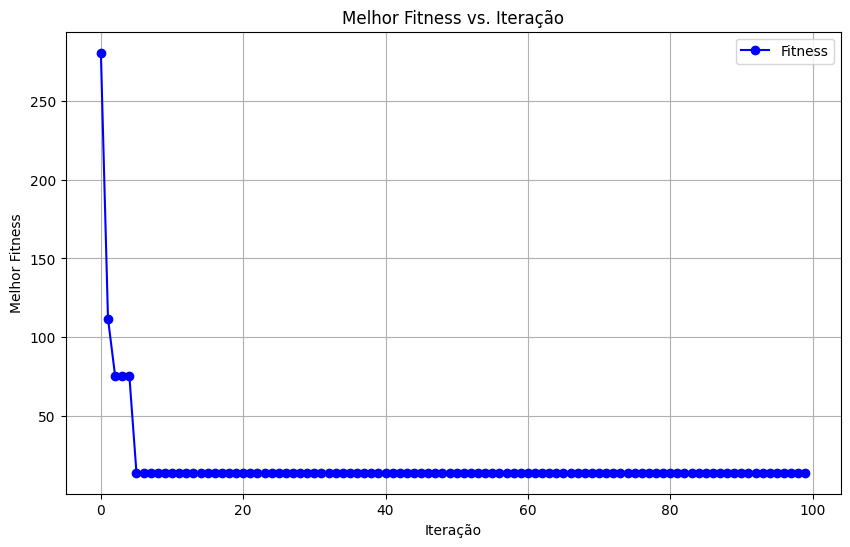

Iteração 100 | Melhor solução: [-9.84736091  2.80498458  0.02761462] | Fitness: 104.83921795154198 | Histórico Fitness: [593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 593.2546933360517, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154198, 104.83921795154

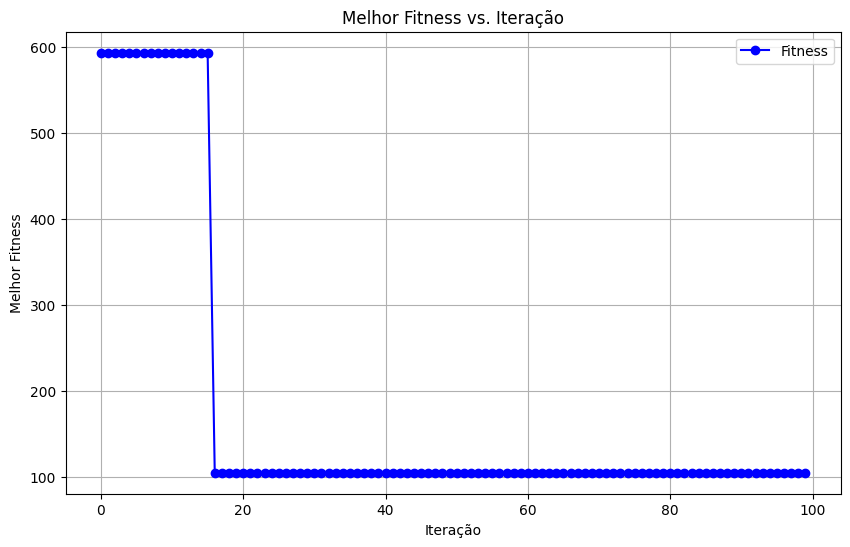

Iteração 100 | Melhor solução: [ 3.75462725 10.2119578   3.41518283] | Fitness: 130.04478167050343 | Histórico Fitness: [1475.5045545922676, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712, 170.36076233624712,

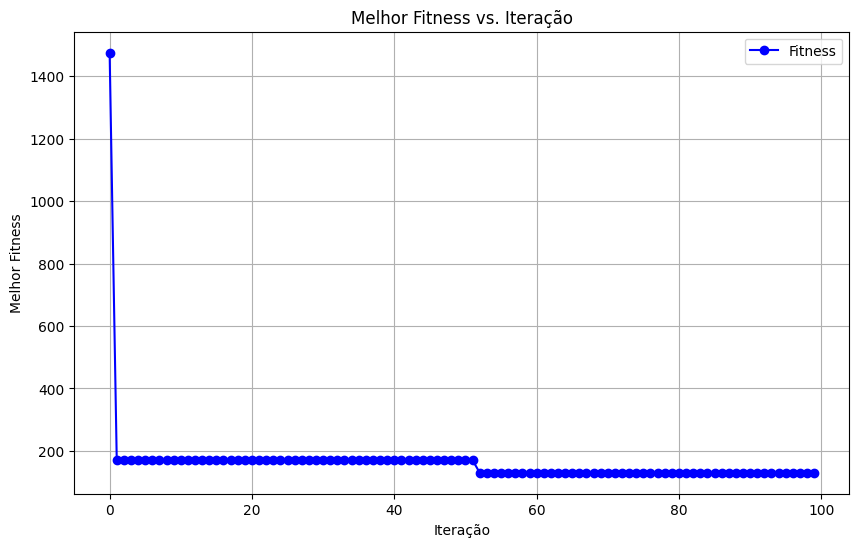

Iteração 100 | Melhor solução: [ 6.24911975  1.98569895 18.0017098 ] | Fitness: 367.0560535237543 | Histórico Fitness: [3815.887390785304, 3815.887390785304, 3815.887390785304, 2090.047022604831, 952.2193155995571, 952.2193155995571, 952.2193155995571, 952.2193155995571, 952.2193155995571, 952.2193155995571, 952.2193155995571, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.1963881889557, 407.19

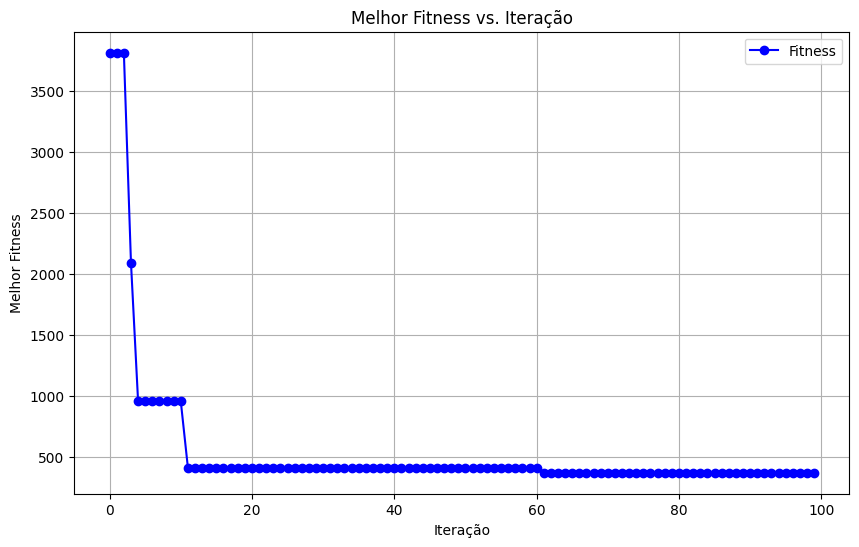

Iteração 100 | Melhor solução: [14.22827075  6.21832056 -7.75441939] | Fitness: 301.2422193845844 | Histórico Fitness: [1420.4465735873928, 1420.4465735873928, 1420.4465735873928, 1161.4449835539478, 1161.4449835539478, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 760.5599404353949, 708.7622110346208, 542.941999960692, 542.941999960692, 542.941999960692, 542.941999960692, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 372.1556998361051, 301.2422193845844, 301.2422193845844, 301.2422193845844, 301.2422193845844, 301.2422193845844, 301.2422193845844, 301.2422193845844, 301.2

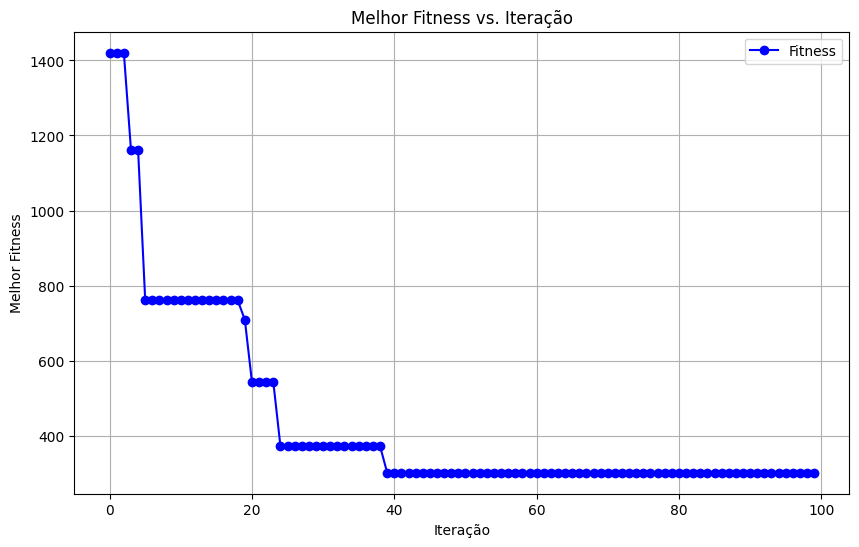

Iteração 100 | Melhor solução: [ 8.56090496 -3.82414553 -8.16255846] | Fitness: 154.54054327491465 | Histórico Fitness: [524.5470996286781, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 252.38768759544672, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 154.54054327491465, 

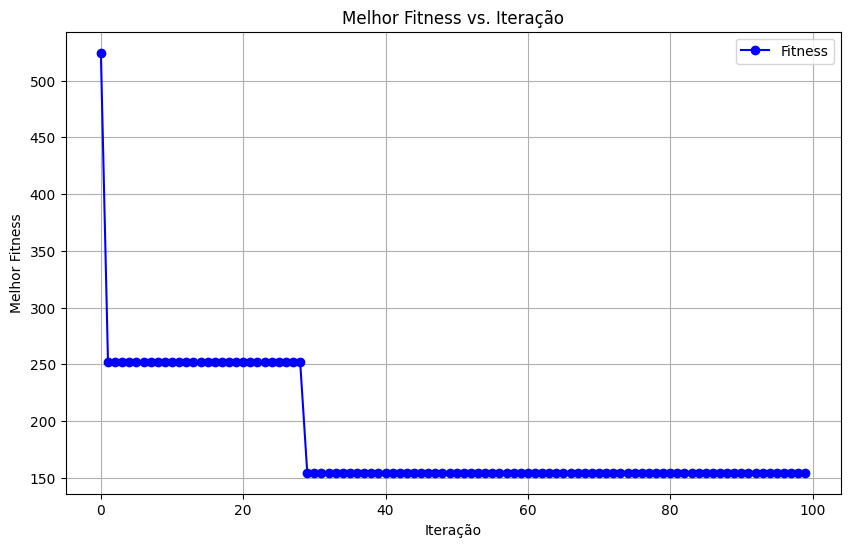

Iteração 100 | Melhor solução: [-3.79557064 -7.0128282  -5.64495005] | Fitness: 95.45157689294697 | Histórico Fitness: [2020.9556903502562, 809.2603113900212, 618.2200965543661, 618.2200965543661, 441.88698843609484, 441.88698843609484, 441.88698843609484, 441.88698843609484, 441.88698843609484, 441.88698843609484, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 131.41613050442254, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45157689294697, 95.45

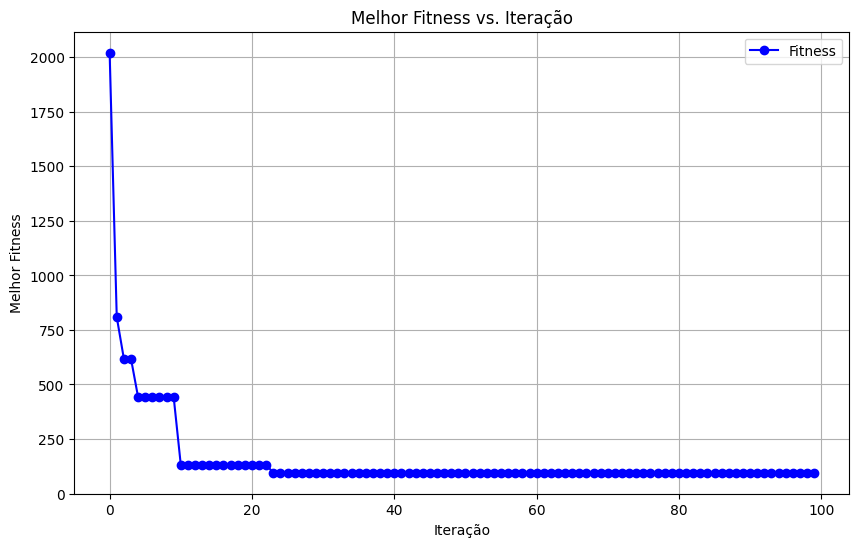

Iteração 100 | Melhor solução: [ 2.23850452 -2.66436774 -2.63756186] | Fitness: 19.066490488845112 | Histórico Fitness: [281.12916829759814, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112, 19.066490488845112,

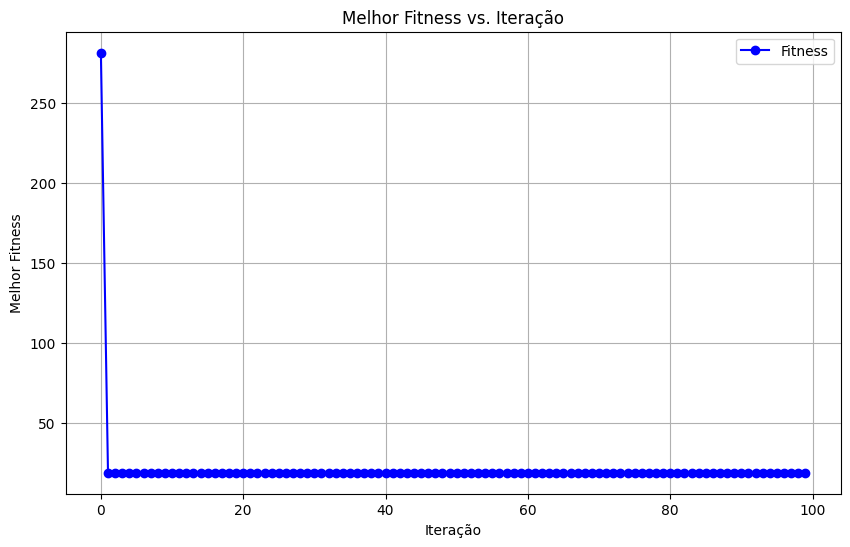

Iteração 100 | Melhor solução: [-11.1023957    0.18829116   4.01044821] | Fitness: 139.38233863133254 | Histórico Fitness: [1976.9259654055588, 252.69782445664413, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.38233863133254, 139.382338631332

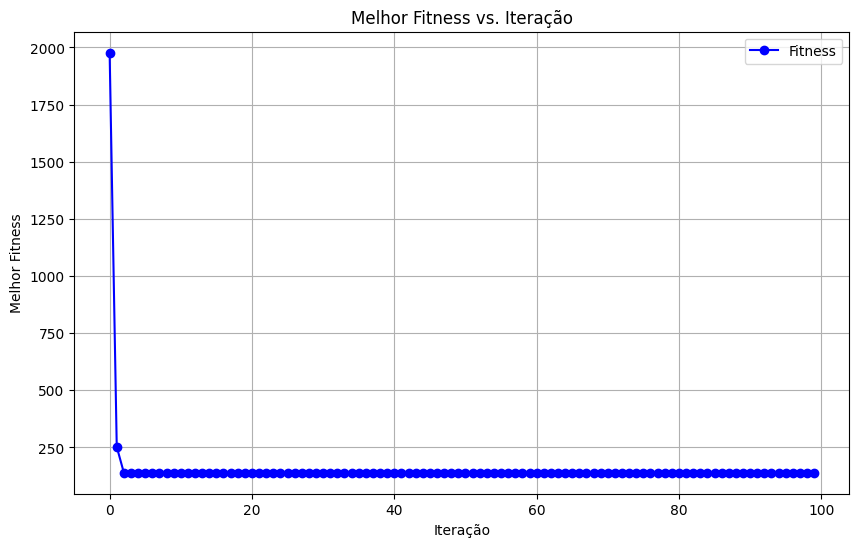

In [230]:
pso0 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso0.otimizar()
pso0.plotar_grafico_convergencia()

pso1 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso1.otimizar()
pso1.plotar_grafico_convergencia()

pso2 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso2.otimizar()
pso2.plotar_grafico_convergencia()

pso3 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso3.otimizar()
pso3.plotar_grafico_convergencia()

pso4 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso4.otimizar()
pso4.plotar_grafico_convergencia()

pso5 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso5.otimizar()
pso5.plotar_grafico_convergencia()

pso6 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso6.otimizar()
pso6.plotar_grafico_convergencia()

pso7 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso7.otimizar()
pso7.plotar_grafico_convergencia()

pso8 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso8.otimizar()
pso8.plotar_grafico_convergencia()

pso9 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.CONSTANTE, Cooperacao.LOCAL_SOCIAL, 5)
pso9.otimizar()
pso9.plotar_grafico_convergencia()

Iteração 100 | Melhor solução: [-2.63646466  3.85078809  0.49112056] | Fitness: 22.020714232895166 | Histórico Fitness: [1708.1487161086982, 1708.1487161086982, 1708.1487161086982, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 388.46287606246693, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704, 193.04562946565704,

C:\Users\Pedro\AppData\Local\Temp\ipykernel_3856\4221234025.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3'])


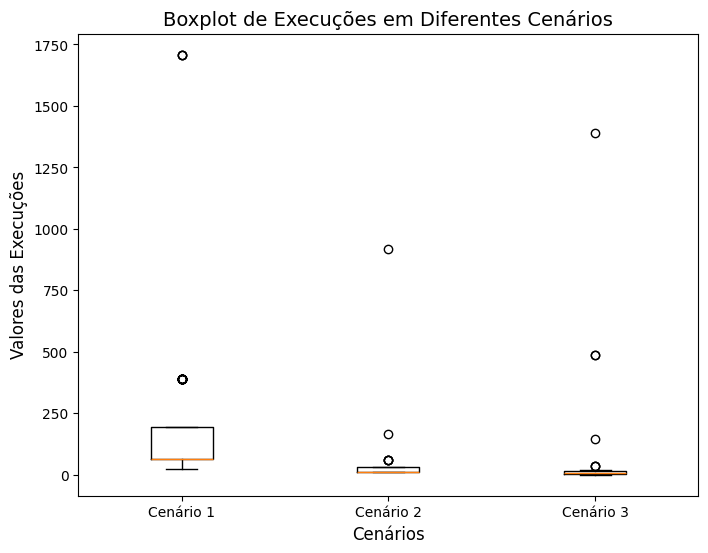

In [231]:
pso1 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.DECAIMENTO_LINEAR, Cooperacao.LOCAL_SOCIAL, 10)
pso1.otimizar()

pso2 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.DECAIMENTO_LINEAR, Cooperacao.LOCAL_GEOGRAFICA, 15)
pso2.otimizar()

pso3 = AlgoritmoEnxameParticulas(sphere, [-100, 100], [-20, 20], [-100, 100], Inercia.DECAIMENTO_LINEAR, Cooperacao.GLOBAL)
pso3.otimizar()

cenario_1 = pso1.melhores_fitness
cenario_2 = pso2.melhores_fitness
cenario_3 = pso3.melhores_fitness

dados = [cenario_1, cenario_2, cenario_3]

# Criando o boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(dados, labels=['Cenário 1', 'Cenário 2', 'Cenário 3'])

# Adicionando título e rótulos aos eixos
plt.title('Boxplot de Execuções em Diferentes Cenários', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

# Mostrando o gráfico
plt.show()

In [232]:
sphere([-3.95929447,  1.57094354, -1.39297962])

20.084268527775656